In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [9]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/client_1_binary.csv")


In [10]:
# Basic structure
print(df.shape)
print(df.info())




(63420, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63420 entries, 0 to 63419
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       63420 non-null  float64
 1   HighBP                63420 non-null  float64
 2   HighChol              63420 non-null  float64
 3   CholCheck             63420 non-null  float64
 4   BMI                   63420 non-null  float64
 5   Smoker                63420 non-null  float64
 6   Stroke                63420 non-null  float64
 7   HeartDiseaseorAttack  63420 non-null  float64
 8   PhysActivity          63420 non-null  float64
 9   Fruits                63420 non-null  float64
 10  Veggies               63420 non-null  float64
 11  HvyAlcoholConsump     63420 non-null  float64
 12  AnyHealthcare         63420 non-null  float64
 13  NoDocbcCost           63420 non-null  float64
 14  GenHlth               63420 non-null  float64
 15  MentHlt

In [11]:
# Check for missing values
print(df.isnull().sum())


Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


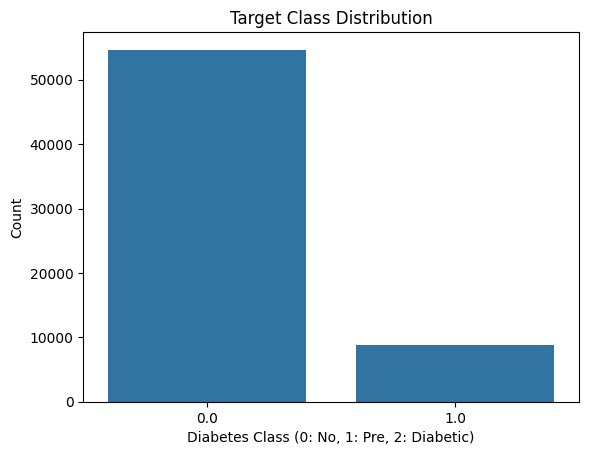

Diabetes_binary
0.0    0.861826
1.0    0.138174
Name: proportion, dtype: float64


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Diabetes_012: 0 = No, 1 = Pre-diabetes, 2 = Diabetes
sns.countplot(x="Diabetes_binary", data=df)
plt.title("Target Class Distribution")
plt.xlabel("Diabetes Class (0: No, 1: Pre, 2: Diabetic)")
plt.ylabel("Count")
plt.show()

# Check imbalance
print(df["Diabetes_binary"].value_counts(normalize=True))


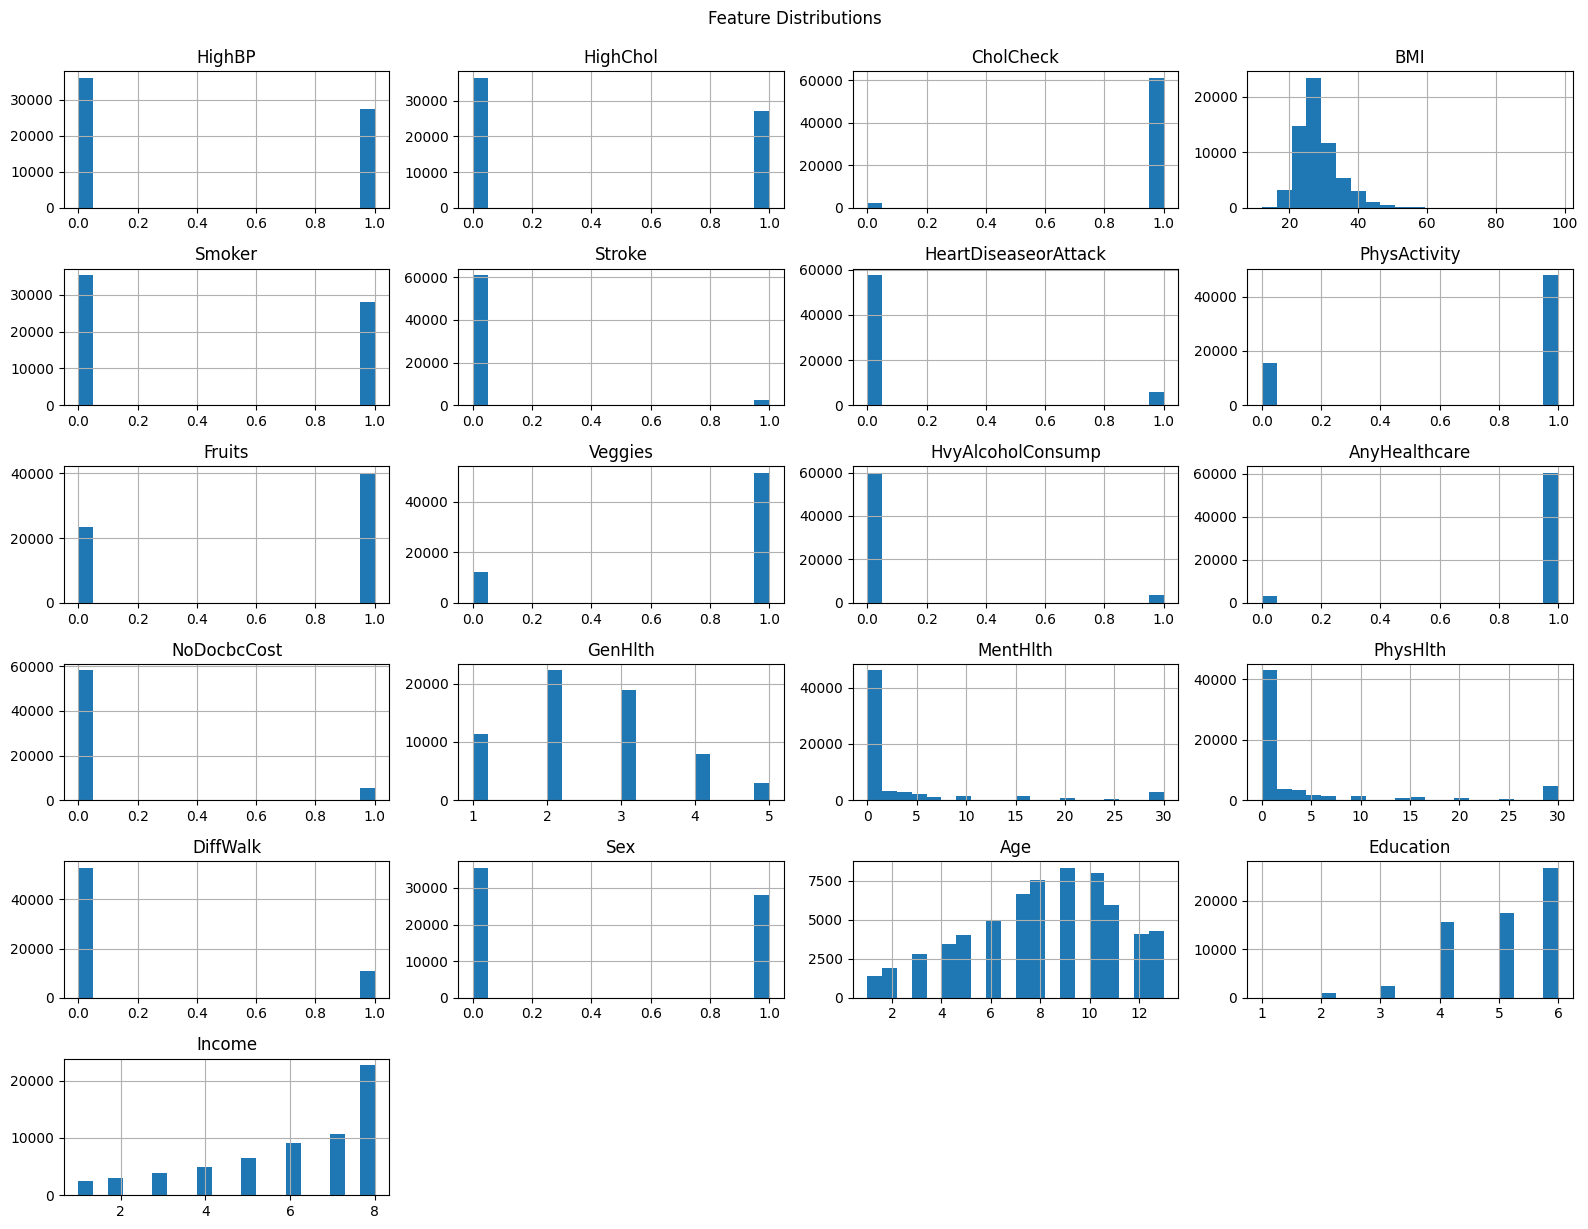

In [13]:
numeric_columns = df.columns.drop("Diabetes_binary")

# Histograms of all features
df[numeric_columns].hist(bins=20, figsize=(16, 12), layout=(6, 4))
plt.tight_layout()
plt.suptitle("Feature Distributions", y=1.02)
plt.show()


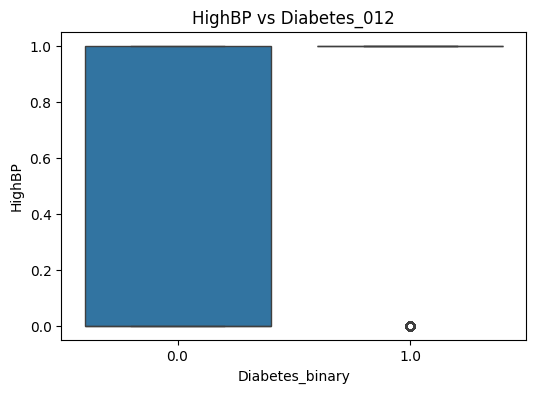

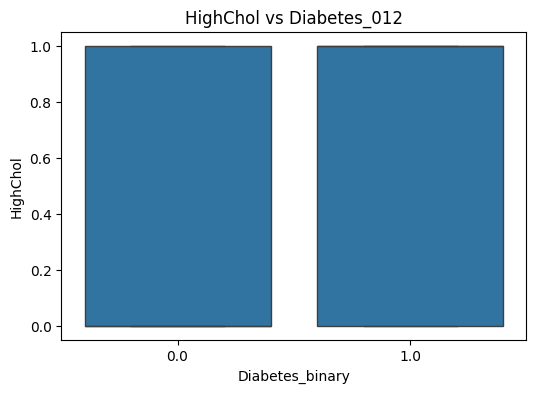

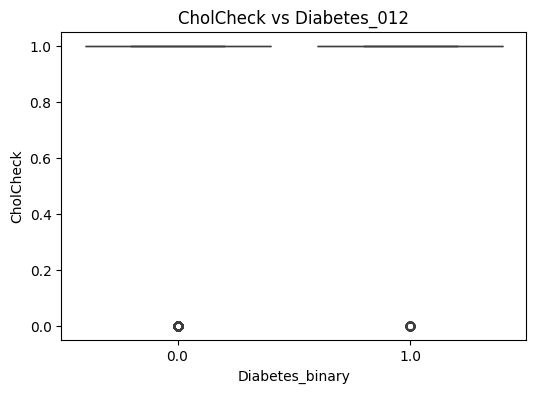

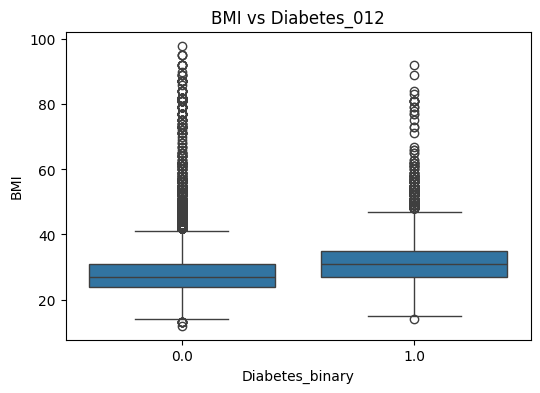

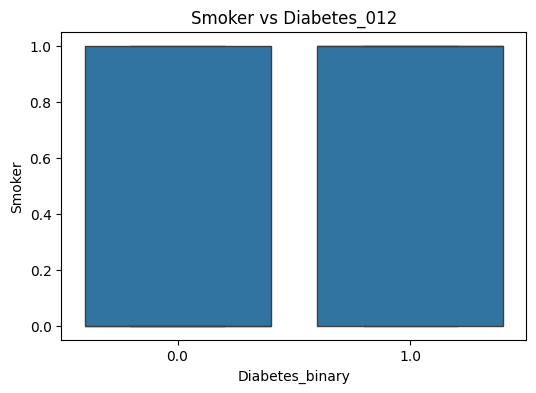

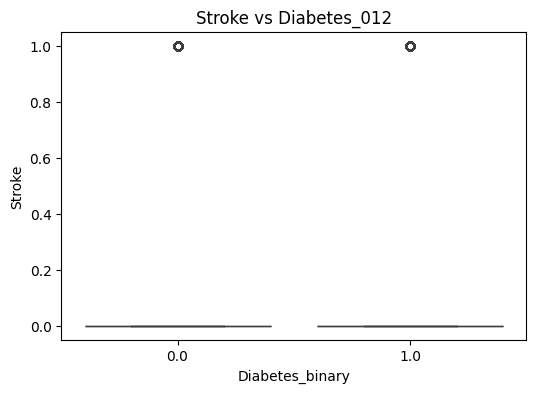

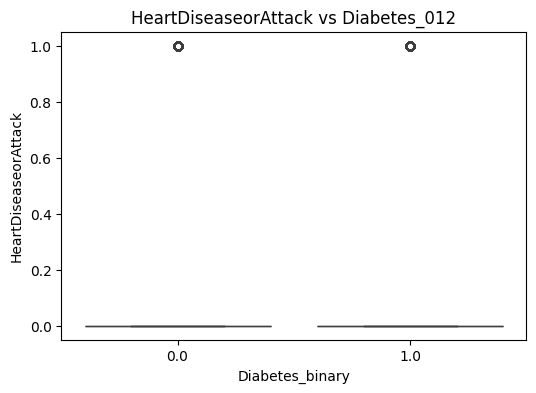

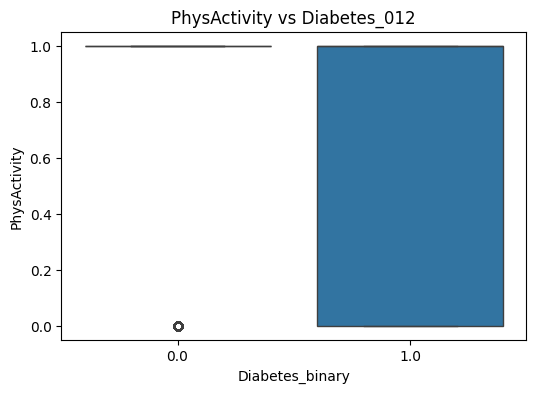

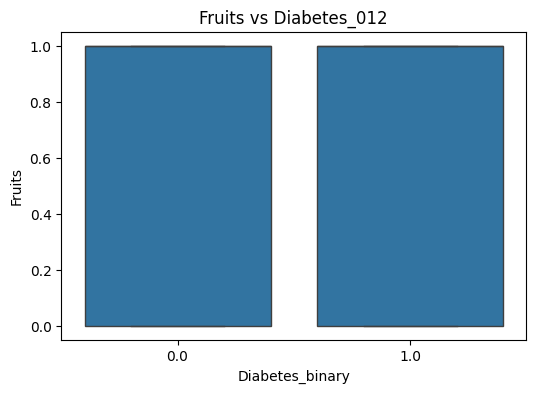

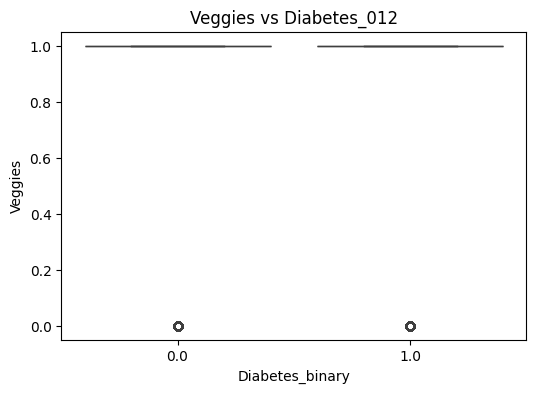

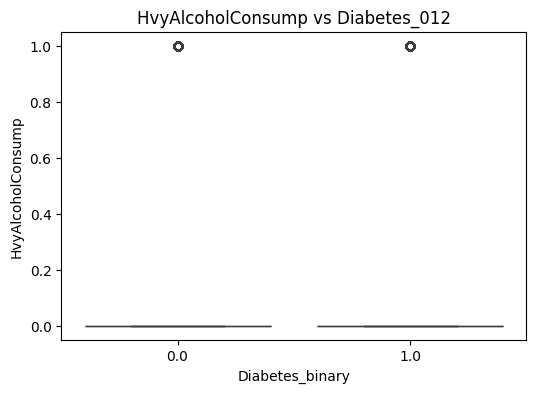

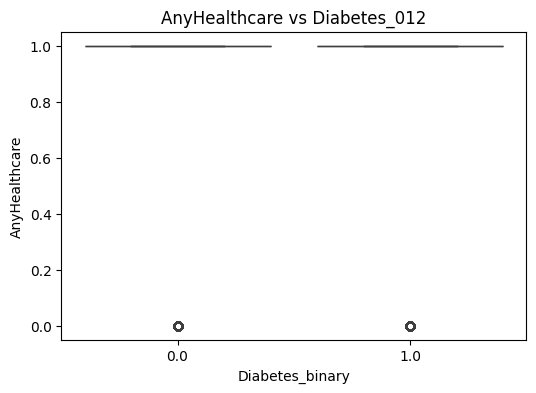

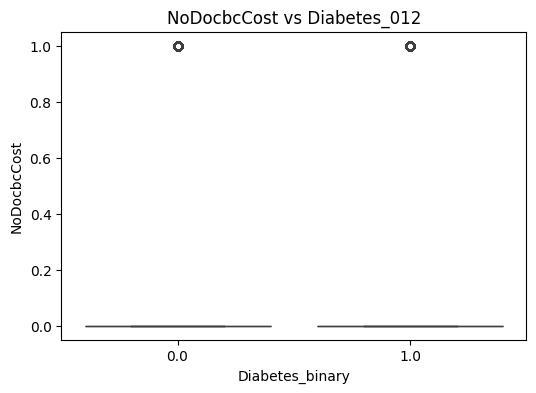

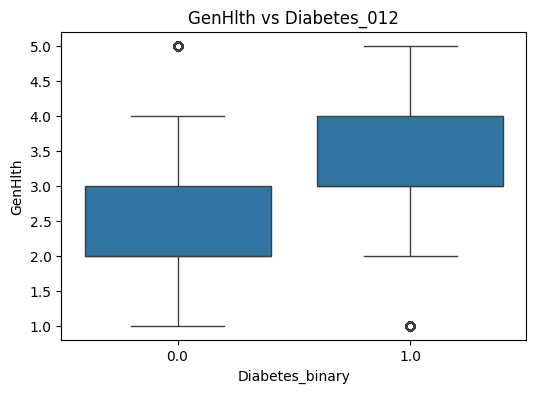

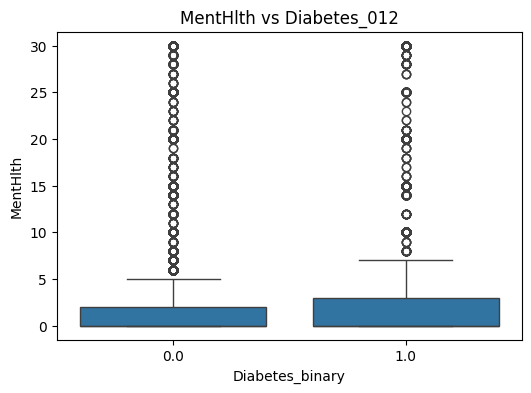

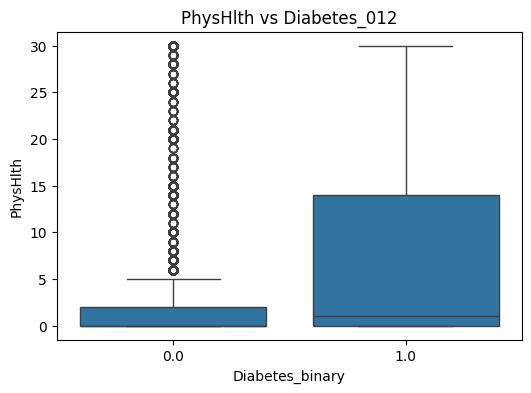

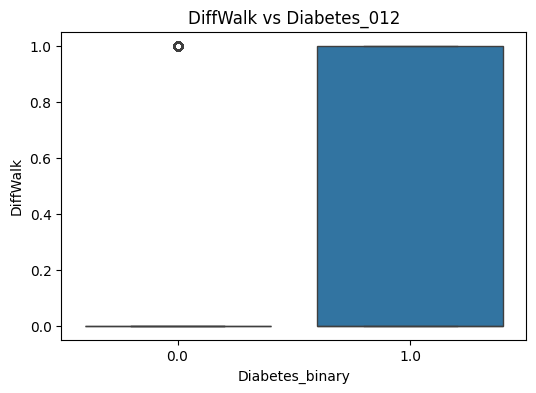

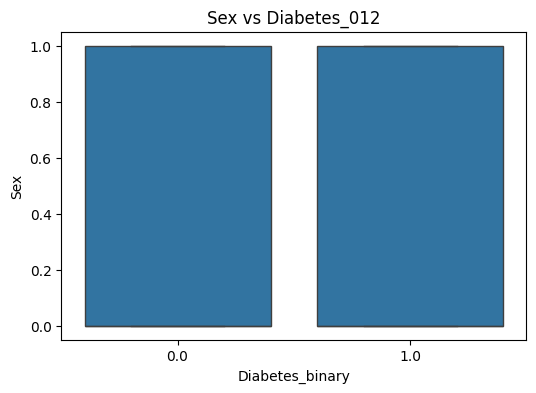

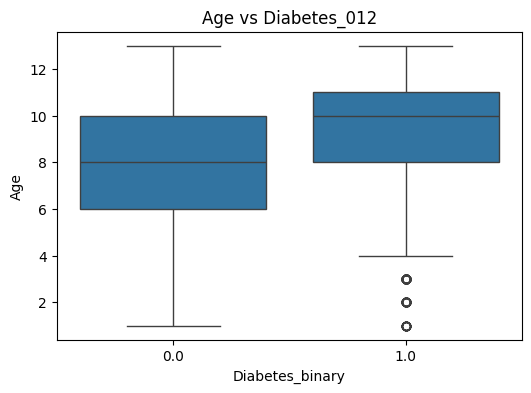

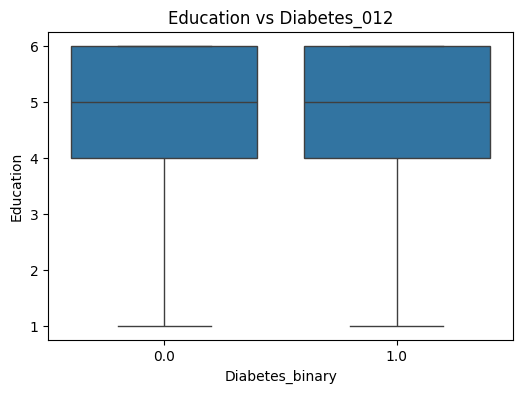

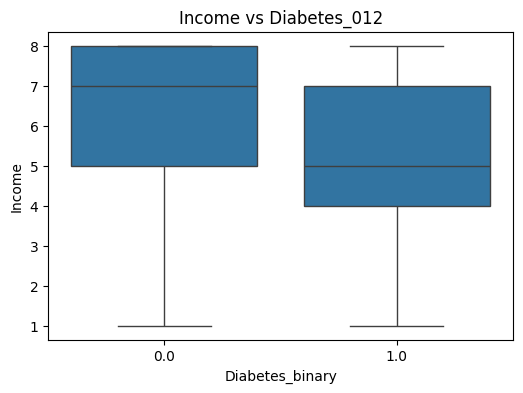

In [ ]:
# # Box plots to compare distributions across classes
# for col in numeric_columns:
#     plt.figure(figsize=(6, 4))
#     sns.boxplot(x="Diabetes_binary", y=col, data=df)
#     plt.title(f"{col} vs Diabetes_012")
#     plt.show()


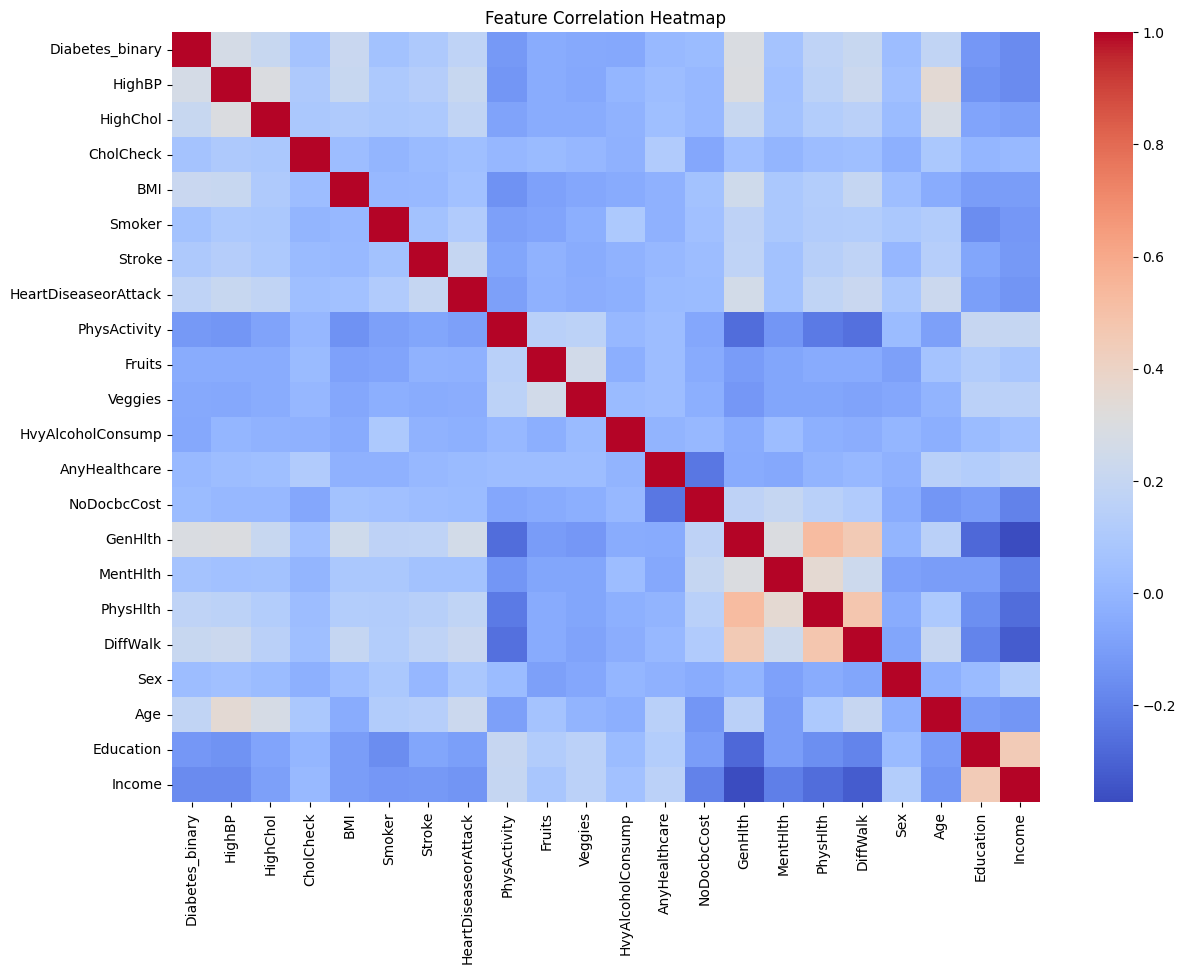

In [14]:
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [7]:
# Sort correlations with target variable
correlation_with_target = df.corr()["Diabetes_binary"].drop("Diabetes_binary").sort_values(ascending=False)
print(correlation_with_target)


GenHlth                 0.292808
HighBP                  0.266274
BMI                     0.213167
DiffWalk                0.209785
HighChol                0.208512
Age                     0.180147
HeartDiseaseorAttack    0.171434
PhysHlth                0.169803
Stroke                  0.100726
MentHlth                0.063971
CholCheck               0.063698
Smoker                  0.058517
Sex                     0.030015
NoDocbcCost             0.025495
AnyHealthcare           0.018244
Fruits                 -0.043717
Veggies                -0.055233
HvyAlcoholConsump      -0.058322
PhysActivity           -0.116527
Education              -0.123165
Income                 -0.165228
Name: Diabetes_binary, dtype: float64


In [15]:
# Separating features and target
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']

In [16]:

# Scaling numerical features
numerical_cols = ['BMI', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


In [17]:
#Step 2: Feature Engineering
# Creating interaction terms for health-related features
X['HighBP_HighChol'] = X['HighBP'] * X['HighChol']
X['HighBP_HeartDisease'] = X['HighBP'] * X['HeartDiseaseorAttack']
X['BMI_PhysActivity'] = X['BMI'] * X['PhysActivity']


In [18]:
# Creating polynomial features for BMI
poly = PolynomialFeatures(degree=2, include_bias=False)
bmi_poly = poly.fit_transform(X[['BMI']])
bmi_poly_cols = [f'BMI_poly_{i+1}' for i in range(bmi_poly.shape[1])]
X[bmi_poly_cols] = bmi_poly

In [19]:
# Binning BMI into categories
X['BMI_binned'] = pd.cut(df['BMI'], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3])

In [20]:
# Creating a health condition aggregate feature
health_conditions = ['HighBP', 'HighChol', 'Stroke', 'HeartDiseaseorAttack']
X['HealthConditionCount'] = X[health_conditions].sum(axis=1)

In [21]:
#Creating a lifestyle score
lifestyle_factors = ['PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump']
X['LifestyleScore'] = X[lifestyle_factors].sum(axis=1)

In [22]:
# Step 3: Handling Class Imbalance
# Checking class distribution
class_distribution = y.value_counts(normalize=True)
print("Class Distribution:\n", class_distribution)

Class Distribution:
 Diabetes_binary
0.0    0.861826
1.0    0.138174
Name: proportion, dtype: float64


In [23]:
# Applying SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [24]:
# Verifying new class distribution
print("Balanced Class Distribution:\n", pd.Series(y_balanced).value_counts(normalize=True))

Balanced Class Distribution:
 Diabetes_binary
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [26]:
# Using mutual information for feature selection
# Fill missing values in 'BMI_binned' with the mode before applying SelectKBest
X_balanced['BMI_binned'] = X_balanced['BMI_binned'].fillna(X_balanced['BMI_binned'].mode()[0])

selector = SelectKBest(score_func=mutual_info_classif, k=15)
X_selected = selector.fit_transform(X_balanced, y_balanced)
selected_features = X_balanced.columns[selector.get_support()].tolist()
print("Selected Features:\n", selected_features)

Selected Features:
 ['HighBP', 'HighChol', 'BMI', 'Smoker', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income', 'HighBP_HighChol', 'BMI_PhysActivity', 'BMI_poly_1', 'BMI_poly_2', 'HealthConditionCount']


In [28]:
#Saving the processed dataset
processed_data = pd.concat([pd.DataFrame(X_selected, columns=selected_features), pd.Series(y_balanced, name='Diabetes_binary')], axis=1)
processed_data.to_csv('processed_diabetes_data.csv', index=False)

# Output summary
print("Feature engineering completed. Processed dataset saved as 'processed_diabetes_data.csv'.")

Feature engineering completed. Processed dataset saved as 'processed_diabetes_data.csv'.


In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the processed dataset
df = pd.read_csv('processed_diabetes_data.csv')

# Define selected features (as provided)
selected_features = [
    'HighBP', 'HighChol', 'BMI', 'Smoker', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age',
    'Education', 'Income', 'HighBP_HighChol', 'BMI_PhysActivity', 'BMI_poly_1',
    'BMI_poly_2', 'HealthConditionCount'
]

# Ensure all selected features are in the dataset
missing_features = [f for f in selected_features if f not in df.columns]
if missing_features:
    raise ValueError(f"Missing features in dataset: {missing_features}")

# Prepare features and target
X = df[selected_features].values
y = df['Diabetes_binary'].values

# Verify binary classification
if len(np.unique(y)) != 2:
    raise ValueError("Target variable 'Diabetes_binary' is not binary. Found classes: ", np.unique(y))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE to oversample minority class
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("Original dataset shape:", Counter(y_train))
print("Resampled dataset shape:", Counter(y_train_res))

# Calculate class weights based on inverse frequency
total_samples = len(y_train_res)
class_weights = {cls: total_samples / (len(np.where(y_train_res == cls)[0]) * 2) for cls in np.unique(y_train_res)}

# Build the neural network model for binary classification
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(len(selected_features),)),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification: sigmoid activation
])

# Compile model with binary cross-entropy loss
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',  # Suitable for binary classification
              metrics=['accuracy'])

# Train the model with early stopping and learning rate reduction
history = model.fit(X_train_res, y_train_res,
                    epochs=100,
                    batch_size=64,
                    validation_split=0.2,
                    class_weight=class_weights,
                    verbose=1,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
                        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
                    ])

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions
accuracy = accuracy_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")

# # Save the trained model
# model.save('diabetes_binary_model.h5')
# print("Model saved as 'diabetes_binary_model.h5'.")

Original dataset shape: Counter({np.float64(1.0): 43829, np.float64(0.0): 43622})
Resampled dataset shape: Counter({np.float64(1.0): 43829, np.float64(0.0): 43829})
Epoch 1/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7291 - loss: 0.5381 - val_accuracy: 0.7663 - val_loss: 0.4890 - learning_rate: 0.0010
Epoch 2/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7547 - loss: 0.5035 - val_accuracy: 0.7671 - val_loss: 0.4868 - learning_rate: 0.0010
Epoch 3/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7580 - loss: 0.4989 - val_accuracy: 0.7700 - val_loss: 0.4807 - learning_rate: 0.0010
Epoch 4/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7623 - loss: 0.4906 - val_accuracy: 0.7748 - val_loss: 0.4752 - learning_rate: 0.0010
Epoch 5/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7668 - loss: 0.4864 - val_accuracy: 0.7795 - val_loss: 0.4694 - learning_rate: 0.0010
Epoch 6/100
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - acc

In [30]:
from sklearn.metrics import classification_report

# Print detailed classification report
report = classification_report(y_test, y_pred_classes, target_names=['No Diabetes', 'Diabetes'])
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.83      0.77      0.80     11035
    Diabetes       0.78      0.84      0.81     10828

    accuracy                           0.80     21863
   macro avg       0.81      0.80      0.80     21863
weighted avg       0.81      0.80      0.80     21863



In [32]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
# For training data
y_train_pred = model.predict(X_train)
y_train_pred_classes = (y_train_pred > 0.5).astype("int32")

print("\nTraining Accuracy:", accuracy_score(y_train, y_train_pred_classes))
print("Training Confusion Matrix:")
print(confusion_matrix(y_train, y_train_pred_classes))
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred_classes, target_names=['No Diabetes', 'Diabetes']))

2733/2733 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

Training Accuracy: 0.8141587860630525
Training Confusion Matrix:
[[33912  9710]
 [ 6542 37287]]
Training Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.84      0.78      0.81     43622
    Diabetes       0.79      0.85      0.82     43829

    accuracy                           0.81     87451
   macro avg       0.82      0.81      0.81     87451
weighted avg       0.82      0.81      0.81     87451



In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# If your model outputs probabilities, convert to class labels
y_train_classes = (y_train_pred > 0.5).astype(int)
y_test_classes = (y_test_pred > 0.5).astype(int)

# Optional: flatten if needed
y_train_classes = y_train_classes.flatten()
y_test_classes = y_test_classes.flatten()

# Print training classification report
print("Training Classification Report:")
print(classification_report(y_train, y_train_classes, target_names=['No Diabetes', 'Diabetes']))

# Print test classification report
print("Test Classification Report:")
print(classification_report(y_test, y_test_classes, target_names=['No Diabetes', 'Diabetes']))

# Optionally print overall accuracy
print("Training Accuracy:", accuracy_score(y_train, y_train_classes))
print("Test Accuracy:", accuracy_score(y_test, y_test_classes))


1586/1586 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
397/397 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training Classification Report:


ValueError: Found input variables with inconsistent numbers of samples: [50736, 152208]